# Main Notebook

In this notebook we will look into the Syria Tel data set. This data set is a telecom companies data on customer churn. We will be looking to make a predictive model based on the given data

### Imports

In [73]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, plot_roc_curve, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

## Data Understanding

We start by looking into the dataset

In [120]:
churn_df = pd.read_csv('./Data/bigml_59c28831336c6604c800002a.csv')
churn_df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


Need to get the columns into a managable format. Currently they all have a space between the words. I will capitalize the first letter of each word then remove the space to create camel cased columns.

In [121]:
churn_df.columns = churn_df.columns.str.title() 

In [122]:
churn_df.columns = churn_df.columns.str.replace(' ','')

In [176]:
churn_df.head()

,State,AccountLength,AreaCode,PhoneNumber,InternationalPlan,VoiceMailPlan,NumberVmailMessages,TotalDayMinutes,TotalDayCalls,TotalDayCharge,...,TotalEveCalls,TotalEveCharge,TotalNightMinutes,TotalNightCalls,TotalNightCharge,TotalIntlMinutes,TotalIntlCalls,TotalIntlCharge,CustomerServiceCalls,Churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [177]:
voice_mail = churn_df.loc[ churn_df['VoiceMailPlan'] == 'yes']

In [178]:
voice_mail['Churn'].value_counts(normalize=True)

False    0.913232
True     0.086768
Name: Churn, dtype: float64

In [180]:
churn_df['VoiceMailPlan'].value_counts(normalize=True)

no     0.723372
yes    0.276628
Name: VoiceMailPlan, dtype: float64

Looking into how the customers are affected by people that have an international plan

In [153]:
Churned_df = churn_df.loc[ churn_df['Churn'] == True]

In [154]:
Non_Churned_df = churn_df.loc[ churn_df['Churn'] == False]

In [161]:
international = churn_df.loc[ churn_df['InternationalPlan'] == 'yes']

In [160]:
international_no = churn_df.loc[ churn_df['InternationalPlan'] == 'no']

In [170]:
international['Churn'].value_counts(normalize=True)

False    0.575851
True     0.424149
Name: Churn, dtype: float64

In [173]:
(137+186)

323

In [172]:
international_no['Churn'].value_counts(normalize=True)

False    0.88505
True     0.11495
Name: Churn, dtype: float64

In [175]:
323 / (2664 + 346 + 323)

0.0969096909690969

Exploring the charges that the cutsomers get how much money the company has lost due to churned customers.

In [124]:
money_df = churn_df.filter(['TotalDayCharge','TotalEveCharge', 'TotalNightCharge', 'TotalIntlCharge', 'AccountLength', 'Churn'], axis=1)

In [125]:
Churned_money = money_df.loc[ churn_df['Churn'] == True]

In [126]:
Non_Churned_money = money_df.loc[ churn_df['Churn'] == False]

In [127]:
Churned_money.sum()

TotalDayCharge      16989.97
TotalEveCharge       8720.55
TotalNightCharge     4460.76
TotalIntlCharge      1395.65
AccountLength       49587.00
Churn                 483.00
dtype: float64

In [144]:
16989.97 + 8720.55 + 4460.76 + 1395.65 

31566.93

In [140]:
Non_Churned_money.sum()

TotalDayCharge       84874.20
TotalEveCharge       48218.89
TotalNightCharge     25667.31
TotalIntlCharge       7818.70
AccountLength       287262.00
Churn                    0.00
dtype: float64

In [145]:
84874.20 + 48218.89 + 25667.31 + 7818.70

166579.1

In [134]:
Non_Churned_money.mean()

TotalDayCharge       29.780421
TotalEveCharge       16.918909
TotalNightCharge      9.006074
TotalIntlCharge       2.743404
AccountLength       100.793684
Churn                 0.000000
dtype: float64

In [129]:
29.780421 + 16.918909 + 9.006074 + 2.743404

58.448808

In [136]:
Churned_money.mean()

TotalDayCharge       35.175921
TotalEveCharge       18.054969
TotalNightCharge      9.235528
TotalIntlCharge       2.889545
AccountLength       102.664596
Churn                 1.000000
dtype: float64

In [137]:
35.175921 + 18.054969 + 9.235528 + 2.889545

65.355963

In [139]:
65.36 - 58.45

6.909999999999997

Found that The churned data on average was charged an average of ~ 7$ more

In [138]:
Non_Churned_money.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2850 entries, 0 to 3332
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TotalDayCharge    2850 non-null   float64
 1   TotalEveCharge    2850 non-null   float64
 2   TotalNightCharge  2850 non-null   float64
 3   TotalIntlCharge   2850 non-null   float64
 4   AccountLength     2850 non-null   int64  
 5   Churn             2850 non-null   bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 136.4 KB


In [147]:
483 / (2850 + 483)

0.14491449144914492

roughly about 15% of our data has churned

In [131]:
money_df.sum()

TotalDayCharge      101864.17
TotalEveCharge       56939.44
TotalNightCharge     30128.07
TotalIntlCharge       9214.35
AccountLength       336849.00
Churn                  483.00
dtype: float64

## Model Creation

In [74]:
X = churn_df.drop(['PhoneNumber', 'Churn'], axis =1)
y = churn_df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=105151)

def grab_numeric(df):
    return df.select_dtypes(include=['float', 'int'])

grab_numeric(X)
GrabNumeric = FunctionTransformer(grab_numeric)

pipe = Pipeline(steps=[
    ('num', GrabNumeric),
    ('ss', StandardScaler())
])
pipe.fit(X)
pipe.transform(X)

In [19]:
subpipe_num = Pipeline(steps=[
    ('ss', StandardScaler())
])


subpipe_cat = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

test = selector(dtype_include=object)

test(X)

In [20]:
CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_num, selector(dtype_include=np.number)),
     ('subpipe_cat', subpipe_cat, selector(dtype_include=object))], remainder='passthrough')


In [21]:
dummy_model_pipe = Pipeline(steps=[
    ('ct', CT),
    ('dum', DummyClassifier(strategy='most_frequent'))
])

In [22]:
logreg_model_pipe = Pipeline([
    ('ct', CT),
    ('logreg', LogisticRegression(random_state=42))
])

In [23]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

### Dummy Model

In [24]:
dummy_pipe = ModelWithCV(dummy_model_pipe, 'dummy_model', X_train, y_train)
dummy_pipe.print_cv_summary()

CV Results for `dummy_model` model:
            0.85354 ± 0.00190 accuracy
        


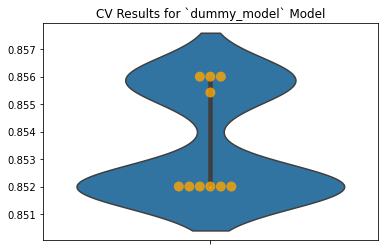

In [25]:
fig, ax = plt.subplots()

dummy_pipe.plot_cv(ax);

### Logistic Regression Model

In [26]:
logreg_pipe = ModelWithCV(logreg_model_pipe, 'logreg_model', X_train, y_train)
logreg_pipe.print_cv_summary()

CV Results for `logreg_model` model:
            0.85955 ± 0.01174 accuracy
        


In [27]:
logreg_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa75266f700>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa75266f340>)])),
                ('logreg', LogisticRegression(random_state=42))])

In [28]:
logreg_model_pipe.score(X_train, y_train)

0.8695478191276511

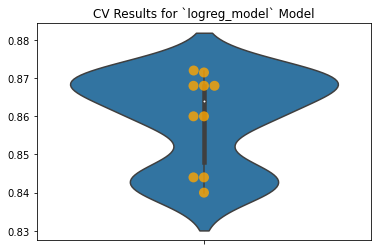

In [29]:
fig, ax = plt.subplots()

logreg_pipe.plot_cv(ax);

### Random Forest

In [30]:
rfc_model_pipe = Pipeline([('ct',CT),('rfc',RandomForestClassifier(random_state=42))])

In [31]:
rfc_pipe = ModelWithCV(rfc_model_pipe, 'rfc_model', X_train, y_train)

rfc_pipe.print_cv_summary()

CV Results for `rfc_model` model:
            0.94078 ± 0.00687 accuracy
        


In [32]:
rfc_pipe = ModelWithCV(rfc_model_pipe, 'rfc_model', X_test, y_test)

rfc_pipe.print_cv_summary()

CV Results for `rfc_model` model:
            0.91723 ± 0.02550 accuracy
        


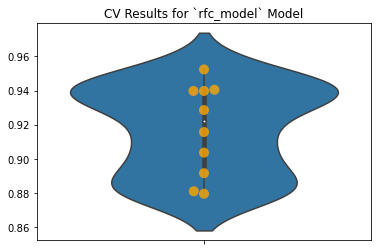

In [33]:
fig, ax = plt.subplots()

rfc_pipe.plot_cv(ax);

### Gradient Booster

In [34]:
gbc = GradientBoostingClassifier(random_state=42)

gbc_model_pipe = Pipeline([('ct', CT), ('gbc',gbc)])

In [35]:
gbc_pipe = ModelWithCV(gbc_model_pipe, 'gbc_model', X_train, y_train)

gbc_pipe.print_cv_summary()

CV Results for `gbc_model` model:
            0.94998 ± 0.01077 accuracy
        


In [36]:
gbc_pipe = ModelWithCV(gbc_model_pipe, 'gbc_model', X_test, y_test)

gbc_pipe.print_cv_summary()

CV Results for `gbc_model` model:
            0.93524 ± 0.01872 accuracy
        


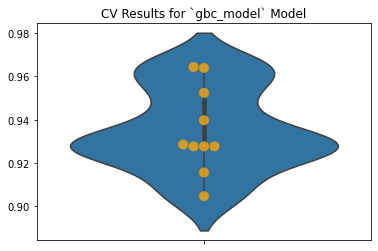

In [37]:
fig, ax = plt.subplots()

gbc_pipe.plot_cv(ax);

In [38]:
RandomForestClassifier()

RandomForestClassifier()

In [27]:
params = {}
params['rfc__criterion'] = ['gini', 'entropy']
params['rfc__min_samples_leaf'] = [1,5,10]

In [28]:
gs = GridSearchCV(rfc_model_pipe,params, cv=10, verbose=1)

In [29]:
gs.fit(X_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   21.1s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fbc464eb370>),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                   

In [30]:
gs.best_params_

{'rfc__criterion': 'entropy', 'rfc__min_samples_leaf': 1}

In [31]:
gs.score(X_train, y_train)

1.0

In [32]:
gs.cv_results_['mean_test_score'].mean()

0.9213028112449798

In [33]:
gs.score(X_test, y_test)

0.9412470023980816

### Target Imbalance

In [34]:
sm = SMOTE(sampling_strategy='auto', random_state=42)

In [35]:
imb_pipe = ImPipeline(steps=[
    ('ct',CT),
    ('sm',SMOTE(random_state=42)),
    ('rfc', RandomForestClassifier(random_state=42))
])

In [36]:
imb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbc464eb370>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbc464eb7c0>)])),
                ('sm', SMOTE(random_state=42)),
                ('rfc', 

In [37]:
imb_pipe.score(X_train, y_train)

1.0

In [38]:
SMOTE()

SMOTE()

In [39]:
parameters = {
    'rfc__criterion':['gini','entropy'],
    'rfc__min_samples_leaf': [1,5,10],
    'rfc__min_samples_split': [2,5,10],
    'rfc__max_features': ['auto', 'sqrt'],
    'sm__k_neighbors': [1,3,5,7],
}


gs = GridSearchCV(imb_pipe, parameters, cv=10, verbose=2)
gs.fit(X_train, y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
[CV] rfc__criterion=gini, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, sm__k_neighbors=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  rfc__criterion=gini, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, sm__k_neighbors=1, total=   0.6s
[CV] rfc__criterion=gini, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, sm__k_neighbors=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  rfc__criterion=gini, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, sm__k_neighbors=1, total=   0.6s
[CV] rfc__criterion=gini, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, sm__k_neighbors=1 
[CV]  rfc__criterion=gini, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, sm__k_neighbors=1, total=   0.6s
[CV] rfc__criterion=gini, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, sm__k_neighbors=1 
[CV]  rfc__criterion=gini, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, sm__k_neighbors=1, total=   0.6s
[CV] rfc__criterion=gini, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, sm__k_neighbors=1 
[CV]  rfc__criterion=gini, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2, sm__k_neighbors=1, total=   0.6s
[CV] rfc__criterion=gini, rfc__max_features=auto, rfc__min_samples_leaf=1, rfc__min_samples_split=2,

KeyboardInterrupt: 

In [ ]:
gs.best_params_

In [39]:
final_model = ImPipeline(steps=[
    ('ct',CT),
    ('sm',SMOTE(random_state=42, k_neighbors=1)),
    ('rfc', RandomForestClassifier(min_samples_leaf=1,max_features= 'auto', min_samples_split= 2, criterion='entropy', random_state=42))
])

In [40]:
final_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa75266f700>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa75266f340>)])),
                ('sm', SMOTE(k_neighbors=1, random_state=42)),
         

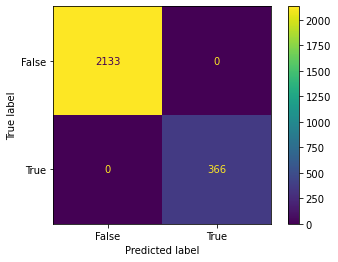

In [41]:
plot_confusion_matrix(final_model, X_train, y_train);

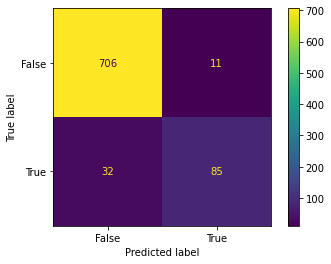

In [42]:
plot_confusion_matrix(final_model, X_test, y_test);

In [43]:
y_hat = final_model.predict(X_test)

In [44]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.95. 

Our final model's recall on the test set is 0.73 

Our final model's precision on the test set is 0.89 

Our final model's f1-score on the test is 0.8.



In [45]:
final_model['rfc'].feature_importances_
feat_import = {name: score 
                   for name, score 
                       in zip(X_train.columns, final_model['rfc'].feature_importances_)
}
feat_import

{'State': 0.026659757239516954,
 'AccountLength': 0.03989814574213442,
 'AreaCode': 0.017525350377948556,
 'InternationalPlan': 0.10427915860634397,
 'VoiceMailPlan': 0.026048985655153074,
 'NumberVmailMessages': 0.09823693489745489,
 'TotalDayMinutes': 0.046188792021484994,
 'TotalDayCalls': 0.024629852720178726,
 'TotalDayCharge': 0.04524854568047146,
 'TotalEveMinutes': 0.0324911822875249,
 'TotalEveCalls': 0.024057937110174652,
 'TotalEveCharge': 0.03285779798089913,
 'TotalNightMinutes': 0.03280128628699614,
 'TotalNightCalls': 0.04883548026531473,
 'TotalNightCharge': 0.03484218477939144,
 'TotalIntlMinutes': 0.1141355747910474,
 'TotalIntlCalls': 0.0013690898436049183,
 'TotalIntlCharge': 0.0009908664552858572,
 'CustomerServiceCalls': 0.0014019708458426893}

In [46]:
values = []
keys = []
for name in feat_import:
    if feat_import[name] > .05:
        keys.append(name)
        values.append(feat_import[name])

In [47]:
keys

['InternationalPlan', 'NumberVmailMessages', 'TotalIntlMinutes']

In [48]:
values

[0.10427915860634397, 0.09823693489745489, 0.1141355747910474]

In [49]:
churn_df['InternationalPlan'] = churn_df['InternationalPlan'].map(dict(yes=1, no=0))
churn_df['VoiceMailPlan'] = churn_df['VoiceMailPlan'].map(dict(yes=1, no=0))

In [50]:


X2 = churn_df.drop(['PhoneNumber', 'Churn', 'State'], axis =1)
y2 = churn_df['Churn']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=105151)
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AccountLength         3333 non-null   int64  
 1   AreaCode              3333 non-null   int64  
 2   InternationalPlan     3333 non-null   int64  
 3   VoiceMailPlan         3333 non-null   int64  
 4   NumberVmailMessages   3333 non-null   int64  
 5   TotalDayMinutes       3333 non-null   float64
 6   TotalDayCalls         3333 non-null   int64  
 7   TotalDayCharge        3333 non-null   float64
 8   TotalEveMinutes       3333 non-null   float64
 9   TotalEveCalls         3333 non-null   int64  
 10  TotalEveCharge        3333 non-null   float64
 11  TotalNightMinutes     3333 non-null   float64
 12  TotalNightCalls       3333 non-null   int64  
 13  TotalNightCharge      3333 non-null   float64
 14  TotalIntlMinutes      3333 non-null   float64
 15  TotalIntlCalls       

In [51]:
def grab_numeric(df):
    return df.select_dtypes(include=['float', 'int'])

grab_numeric(X2)
GrabNumeric = FunctionTransformer(grab_numeric)

In [52]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)

In [53]:
tree_clf.fit(X_train2, y_train2)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [72]:
y_preds = tree_clf.predict(X_test2)

In [55]:
acc = accuracy_score(y_test2, y_preds)
acc

0.8872901678657075

In [56]:
tree_clf.score(X_test2, y_test2)

0.8872901678657075

In [57]:
tree_clf.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.14109778,
       0.        , 0.        , 0.44725823, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.41164399])

In [58]:
feat_import = {name: score 
                   for name, score 
                       in zip(X_train.columns, tree_clf.feature_importances_)
}
feat_import

{'State': 0.0,
 'AccountLength': 0.0,
 'AreaCode': 0.0,
 'InternationalPlan': 0.0,
 'VoiceMailPlan': 0.14109777782085517,
 'NumberVmailMessages': 0.0,
 'TotalDayMinutes': 0.0,
 'TotalDayCalls': 0.44725823414127946,
 'TotalDayCharge': 0.0,
 'TotalEveMinutes': 0.0,
 'TotalEveCalls': 0.0,
 'TotalEveCharge': 0.0,
 'TotalNightMinutes': 0.0,
 'TotalNightCalls': 0.0,
 'TotalNightCharge': 0.0,
 'TotalIntlMinutes': 0.0,
 'TotalIntlCalls': 0.0,
 'TotalIntlCharge': 0.41164398803786545}

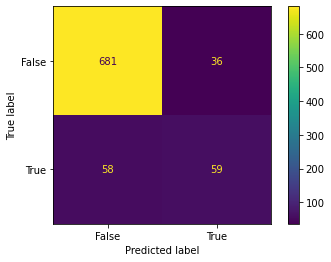

In [59]:
plot_confusion_matrix(tree_clf, X_test2, y_test2)

In [60]:
tree_clf.fit(X2,y2)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [61]:
gbs2 = GradientBoostingClassifier(random_state=42)

In [62]:
gbs2.fit(X_train2, y_train2)

GradientBoostingClassifier(random_state=42)

In [63]:
gbs2.score(X_test2, y_test2)

0.9580335731414868

In [64]:
gbs2.feature_importances_

array([2.70962644e-03, 6.03931695e-06, 8.85708370e-02, 4.68278329e-02,
       4.40844858e-02, 1.37077925e-01, 3.80481143e-03, 1.63988163e-01,
       5.95215548e-02, 3.13508449e-03, 7.16985338e-02, 1.46853563e-02,
       3.96072116e-03, 1.17181682e-02, 5.21619247e-02, 9.65627344e-02,
       3.53563917e-02, 1.64129810e-01])

In [65]:
gbs2.feature_importances_
gbs2_feat_import = {name: score 
                   for name, score 
                       in zip(X_train.columns, gbs2.feature_importances_)
}
gbs2_feat_import

{'State': 0.0027096264353824334,
 'AccountLength': 6.039316952340861e-06,
 'AreaCode': 0.08857083696509697,
 'InternationalPlan': 0.04682783287830361,
 'VoiceMailPlan': 0.04408448580849404,
 'NumberVmailMessages': 0.13707792482691084,
 'TotalDayMinutes': 0.003804811431790863,
 'TotalDayCalls': 0.163988163008888,
 'TotalDayCharge': 0.059521554752904306,
 'TotalEveMinutes': 0.0031350844941217047,
 'TotalEveCalls': 0.07169853384259398,
 'TotalEveCharge': 0.014685356250791906,
 'TotalNightMinutes': 0.003960721156047774,
 'TotalNightCalls': 0.01171816821127761,
 'TotalNightCharge': 0.0521619246999282,
 'TotalIntlMinutes': 0.09656273439170877,
 'TotalIntlCalls': 0.035356391728283636,
 'TotalIntlCharge': 0.16412980980052308}

In [66]:
gbs2_values = []
gbs2_keys = []
for name in gbs2_feat_import:
    if feat_import[name] > .05:
        gbs2_keys.append(name)
        gbs2_values.append(feat_import[name])

In [67]:
gbs2_keys

['VoiceMailPlan', 'TotalDayCalls', 'TotalIntlCharge']

In [68]:
final_model['rfc'].feature_importances_
final_feat_import = {name: score 
                   for name, score 
                       in zip(X_train.columns, final_model['rfc'].feature_importances_)
}
final_feat_import

{'State': 0.026659757239516954,
 'AccountLength': 0.03989814574213442,
 'AreaCode': 0.017525350377948556,
 'InternationalPlan': 0.10427915860634397,
 'VoiceMailPlan': 0.026048985655153074,
 'NumberVmailMessages': 0.09823693489745489,
 'TotalDayMinutes': 0.046188792021484994,
 'TotalDayCalls': 0.024629852720178726,
 'TotalDayCharge': 0.04524854568047146,
 'TotalEveMinutes': 0.0324911822875249,
 'TotalEveCalls': 0.024057937110174652,
 'TotalEveCharge': 0.03285779798089913,
 'TotalNightMinutes': 0.03280128628699614,
 'TotalNightCalls': 0.04883548026531473,
 'TotalNightCharge': 0.03484218477939144,
 'TotalIntlMinutes': 0.1141355747910474,
 'TotalIntlCalls': 0.0013690898436049183,
 'TotalIntlCharge': 0.0009908664552858572,
 'CustomerServiceCalls': 0.0014019708458426893}

In [69]:
final_values = []
final_keys = []
for name in final_feat_import:
    if final_feat_import[name] > .05:
        final_keys.append(name)
        final_values.append(final_feat_import[name])

In [70]:
final_keys

['InternationalPlan', 'NumberVmailMessages', 'TotalIntlMinutes']